### Sentinel 2 - Timeseries analysis
NDVI, LAI, FAPAR, FCOVER, CAB

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import xarray as xr
from pyproj import CRS, Transformer

import distributed
client = distributed.Client()

/home/vhutter/anaconda3/envs/s3_zarr_gdal/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34915 instead
  warnings.warn(


In [2]:
def reproject(spatial_extent_dict: dict = None, x = None, y = None, crs = None):
    if spatial_extent_dict: 
        if not crs:
            crs = spatial_extent_dict["crs"]
        if "4326" in str(crs):
            return spatial_extent_dict
        else:
            transformer = Transformer.from_crs(crs, 4326, always_xy=True)
            west, south = transformer.transform(
                spatial_extent_dict["west"], spatial_extent_dict["south"]
            )
            east, north = transformer.transform(
                spatial_extent_dict["east"], spatial_extent_dict["north"]
            )
            return {
                "west": west,
                "east": east,
                "south": south,
                "north": north,
                "crs": "4326",
            }
    if x and y and crs:
        transformer = Transformer.from_crs(crs, 4326, always_xy=True)
        lon, lat = transformer.transform(
            x, y
        )
        return {"lon": lon, "lat": lat}

In [3]:
def get_file_list(spatial_extent_dict: dict):
    utm_grid = "utm-tiles.geojson"
    utm = gpd.read_file(utm_grid)
    polygon = Polygon(
        [
            [spatial_extent_dict["west"], spatial_extent_dict["south"]],
            [spatial_extent_dict["west"], spatial_extent_dict["north"]],
            [spatial_extent_dict["east"], spatial_extent_dict["north"]],
            [spatial_extent_dict["east"], spatial_extent_dict["south"]],
        ]
    )
    intersection = []
    for i, geom in enumerate(utm.geometry):
        if geom.intersects(polygon):
            intersection.append(utm.Name[i])
    return intersection

# enter the longitude and latitude and use the utm-grid to get the tile
spatial_extent = {"west": 15.649, "east": 15.65, "south": 48.55, "north": 48.551, "crs": 4326}

spatial_extent_4326 = reproject(spatial_extent)

tiles = get_file_list(spatial_extent)

tile = "T" + tiles[0]
print(tile)

transformer = Transformer.from_crs(4326, 32633, always_xy=True)
west, south = transformer.transform(
    spatial_extent["west"], spatial_extent["south"]
)
east, north = transformer.transform(
    spatial_extent["east"], spatial_extent["north"]
)

polygon = Polygon(
    [
        [west, south],
        [west, north],
        [east, north],
        [east, south],
    ]
)

T33UWP


In [4]:
# pick an item from the list provided and get the tile and polygon from there
fields = gpd.read_file("test_felder.json")
tile = fields["Name"][2]
polygon = fields["geometry"][2]
xp,yp = polygon.exterior.xy
tile

'T33UWP'

In [5]:
fields

,Name,ID,geometry
0,T33UWP,2,"POLYGON ((536705.268 5391543.460, 536696.350 5..."
1,T33UWQ,2,"POLYGON ((536705.268 5391543.460, 536696.350 5..."
2,T33UWP,3,"POLYGON ((537162.810 5391790.199, 537140.388 5..."
3,T33UWQ,3,"POLYGON ((537162.810 5391790.199, 537140.388 5..."
4,T33UWP,4,"POLYGON ((537685.378 5392259.977, 537746.652 5..."
...,...,...,...
67330,T33UWP,94959,"POLYGON ((576611.135 5348605.970, 576605.393 5..."
67331,T33UWP,94960,"POLYGON ((574114.200 5348727.608, 574108.863 5..."
67332,T33UXP,94961,"POLYGON ((613158.176 5311742.847, 613152.318 5..."
67333,T33UWP,94972,"POLYGON ((504124.156 5326259.871, 504131.532 5..."


In [6]:
data = xr.open_zarr(f"https://objectstore.eodc.eu:2222/68e13833a1624f43ba2cac01376a18af:indices/s2-bands-{tile}.zarr", chunks="auto")

data

<xarray.Dataset> Size: 42GB
Dimensions:      (time: 50, y: 10980, x: 10980)
Coordinates:
  * time         (time) <U48 10kB '2024-06-30T09:57:25.299000000' ... '2024-0...
  * x            (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y            (y) float64 88kB 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
Data variables:
    blue         (time, y, x) uint16 12GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 12GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) uint16 12GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    scl          (time, y, x) uint8 6GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    spatial_ref  int32 4B ...

In [7]:
i = np.argmin(abs(polygon.centroid.x - data.x.values))
j = np.argmin(abs(polygon.centroid.y - data.y.values))
print(i, j)
a, b = 3000, 3000
if i < 3000 or j < 3000:
    a = np.min([i,j])
if i > np.max(data.x.values) - 3000 or j > np.max(data.y.values) - 3000:
    b = np.min([i, j])


data = data.sortby("time")

t = [(str(time)[:10]) for time in data["time"].values]
t = np.array(t, dtype="datetime64")
print(t[0], t[-1])

crs = int(data["spatial_ref"].values)
print("CRS: ", crs)

x = data["x"][i]
y = data["y"][j]

lon, lat = reproject(x = x, y = y, crs = crs)["lon"], reproject(x = x, y = y, crs = crs)["lat"]

3713 814
2024-01-10 2024-12-30
CRS:  32633


In [8]:
t0 = 21

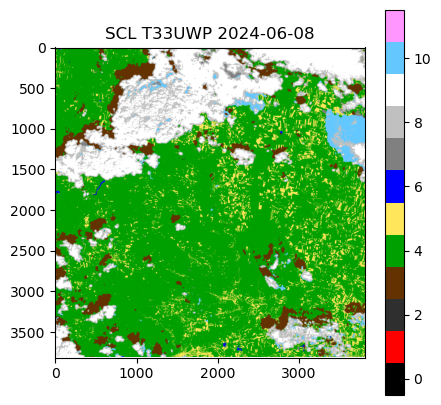

In [9]:
# SCL colormap
from matplotlib import colors

scl_colors = ['#000000', '#FF0000', '#2f2f2f', '#643200', '#00a000', '#ffe65a', '#0000ff', '#808080', '#c0c0c0', '#ffffff', '#64c8ff', '#ff96ff']
scl_cmap = colors.ListedColormap(scl_colors, name="scl")

plt.figure(figsize=(5,5))
plt.title(f'SCL {tile} {data["time"].values[t0][:10]}')
plt.imshow(data.scl[t0, j-a:j+b, i-a:i+b], cmap=scl_cmap, vmin=-0.5, vmax=11.5)
# plt.plot(xp,yp)
plt.colorbar()
plt.show()

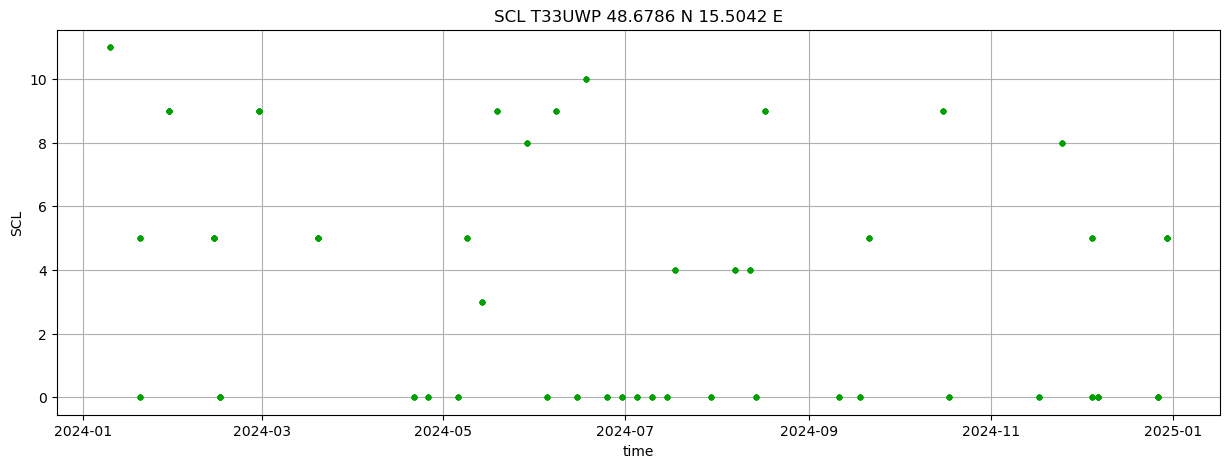

In [10]:
plt.figure(figsize=(15,5))
plt.title(f'SCL {tile} {np.round(lat, 4)} N {np.round(lon, 4)} E')
for xi in range(3):
    for yi in range(3):
        plt.plot(t, data.scl[:, j-1+yi, i-1+xi], ".", c='#00a000')
plt.xlabel("time")
plt.ylabel("SCL")
plt.grid()
plt.show()

In [11]:
def tone_mapping(data):
    red = data.red[t0, j-a:j+b, i-a:i+b].values
    green = data.green[t0, j-a:j+b, i-a:i+b].values
    blue = data.blue[t0, j-a:j+b, i-a:i+b].values
    red = (red+1)/1733*255
    green = (green+1)/1630*255
    blue = (blue+1)/1347*255
    red = np.clip(red,0,255).astype(np.uint8)
    green = np.clip(green,0,255).astype(np.uint8)
    blue = np.clip(blue,0,255).astype(np.uint8)
    brg = np.zeros((red.shape[0],red.shape[1],3),dtype=np.uint8)
    brg[:,:,0] = red
    brg[:,:,1] = green
    brg[:,:,2] = blue
    return brg

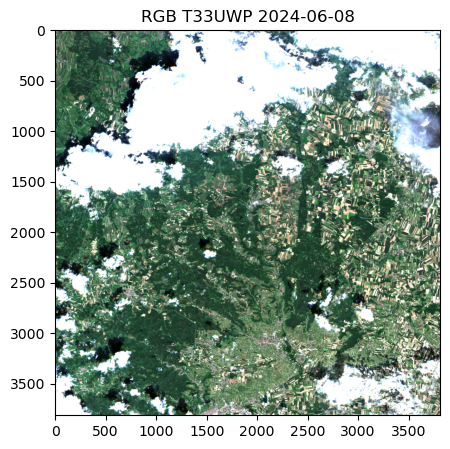

In [12]:
plt.figure(figsize=(15,5))
plt.title(f'RGB {tile} {data["time"].values[t0].astype(str)[:10]}')
plt.imshow(tone_mapping(data), cmap='brg')
plt.show()

3713 814
2024-01-10 2024-12-30
CRS:  32633


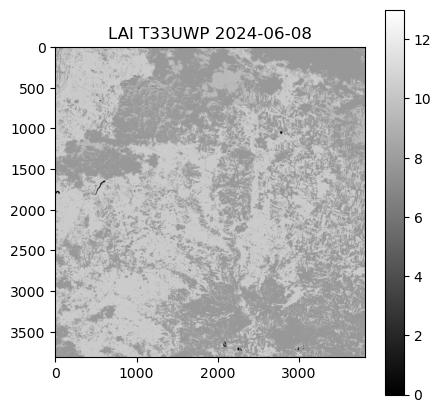

In [13]:
data = xr.open_zarr(f"https://objectstore.eodc.eu:2222/68e13833a1624f43ba2cac01376a18af:indices/s2-indices-{tile}.zarr", chunks="auto")

i = np.argmin(abs(polygon.centroid.x - data.x.values))
j = np.argmin(abs(polygon.centroid.y - data.y.values))
print(i, j)
a, b = 3000, 3000
if i < 3000 or j < 3000:
    a = np.min([i,j])
if i > np.max(data.x.values) - 3000 or j > np.max(data.y.values) - 3000:
    b = np.min([i, j])

data = data.sortby("time")

t = [(str(time)[:10]) for time in data["time"].values]
t = np.array(t, dtype="datetime64")
print(t[0], t[-1])

crs = int(data["spatial_ref"].values)
print("CRS: ", crs)

x = data["x"][i]
y = data["y"][j]

lon, lat = reproject(x = x, y = y, crs = crs)["lon"], reproject(x = x, y = y, crs = crs)["lat"]

t0 = 15

plt.figure(figsize=(5,5))
plt.title(f'LAI {tile} {data["time"].values[t0][:10]}')
plt.imshow(data.lai[t0, j-a:j+b, i-a:i+b], cmap="gray", vmin=0, vmax=13)
plt.colorbar()
plt.show()

In [14]:
data["time"].values[-5]

'2024-11-25T10:07:20.936000000'

2025-01-29 15:33:06,539 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-lai-90976cdb9e1fe0e9435a3508b27e1e07' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7f0cf2297920>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7f0ca97b3280>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x7f0cf2297920>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array

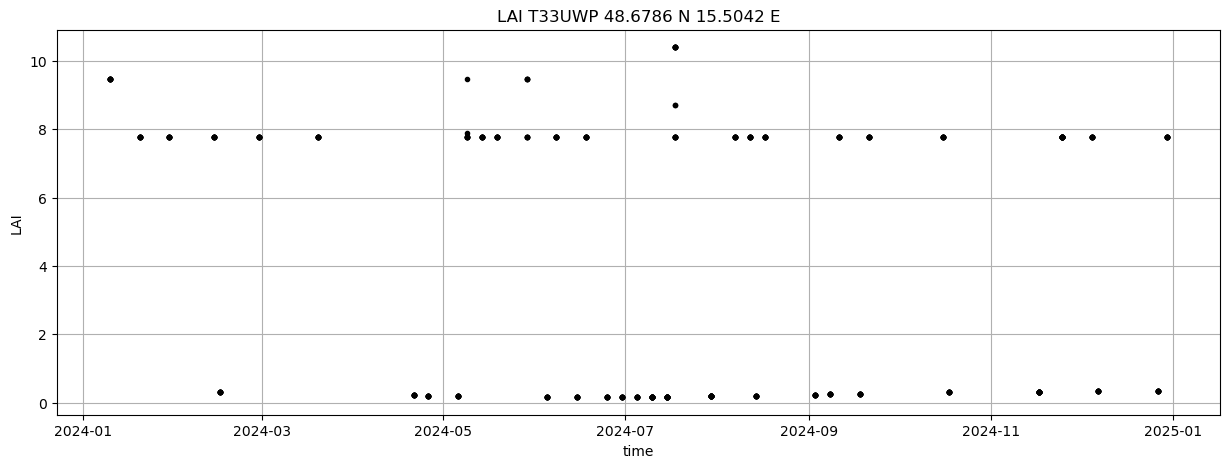

In [15]:
plt.figure(figsize=(15,5))
plt.title(f'LAI {tile} {np.round(lat, 4)} N {np.round(lon, 4)} E')
for xi in range(3):
    for yi in range(3):
        plt.plot(t, data.lai[:, j-1+yi, i-1+xi], ".", c='k')
plt.xlabel("time")
plt.ylabel("LAI")
plt.grid()
plt.show()

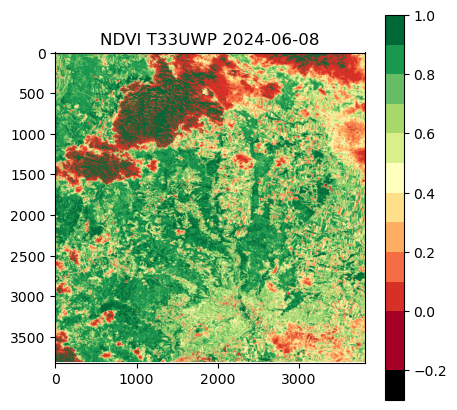

In [16]:
# NDVI colormap
from matplotlib import colors

ndvi_colors = ['#000000', '#a50026', '#a50026', '#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837']
ndvi_cmap = colors.ListedColormap(ndvi_colors, name="ndvi")


plt.figure(figsize=(5,5))
plt.title(f'NDVI {tile} {data["time"].values[t0][:10]}')
plt.imshow(data.ndvi[t0, j-a:j+b, i-a:i+b], vmin=-0.3, vmax=1, cmap=ndvi_cmap)
plt.colorbar()
plt.show()

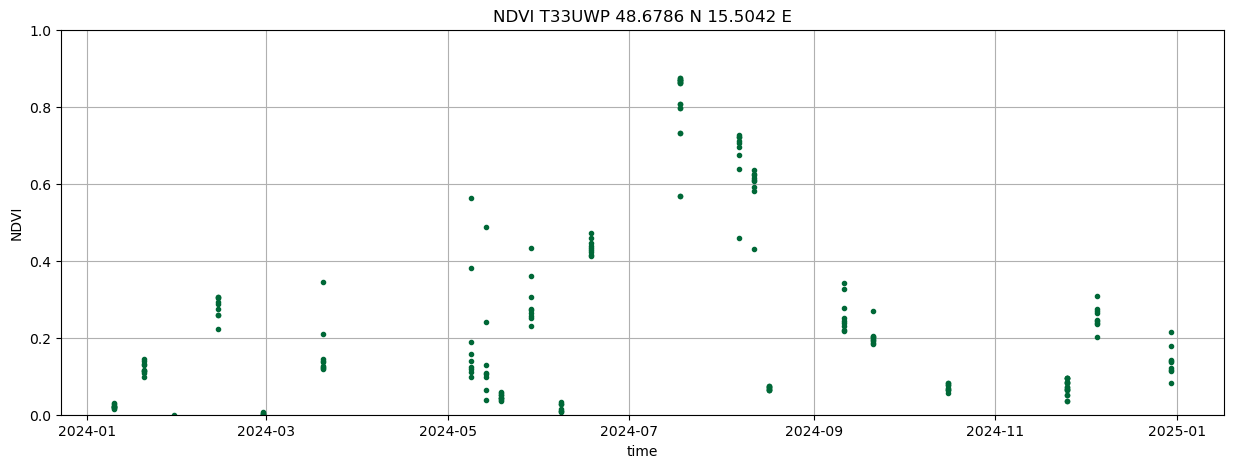

In [17]:
plt.figure(figsize=(15,5))
plt.title(f'NDVI {tile} {np.round(lat, 4)} N {np.round(lon, 4)} E')
for xi in range(3):
    for yi in range(3):
        plt.plot(t, data.ndvi[:, j-1+yi, i-1+xi], ".", c='#006837')
plt.xlabel("time")
plt.ylabel("NDVI")
plt.ylim(0,1)
plt.grid()
plt.show()

In [18]:
import rasterio
from datacube.utils.geometry import Geometry

def geometry_mask(polygon, data):
    bbox = polygon.bounds
    data_part = data.sel(x=slice(bbox[0],bbox[2]), y=slice(bbox[3],bbox[1])).compute()
    data_part = data_part.where(data_part <=1, np.nan)
    geom = Geometry(polygon, crs=CRS.from_epsg(32633))
    geobox = data_part.geobox
    mask = rasterio.features.geometry_mask(
        [geom],
        out_shape=geobox.shape,
        transform=geobox.affine,
        all_touched=False,
        invert=True,
    )
    return data_part.where(mask, np.nan)

data_mask = geometry_mask(
    polygon,
    data.ndvi,
)


In [19]:
NDVI = data_mask.mean(dim=["y", "x"], skipna=True)
NDVI

<xarray.DataArray 'ndvi' (time: 50)> Size: 400B
array([0.03070937, 0.20673293, 0.00378043, 0.27321499,        nan,
       0.0037029 , 0.21581456,        nan,        nan,        nan,
       0.27231279, 0.21357565, 0.11532918, 0.30140473,        nan,
       0.04981704,        nan, 0.44757216,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.7929214 , 0.7929214 ,        nan,        nan, 0.64575139,
       0.55623084,        nan, 0.06025467,        nan,        nan,
       0.27051919,        nan, 0.26474857, 0.07604314,        nan,
              nan,        nan,        nan,        nan, 0.08319259,
       0.08319259, 0.29022248,        nan,        nan, 0.21939629])
Coordinates:
    spatial_ref  int32 4B 32633
  * time         (time) <U48 10kB '2024-01-10T10:07:17.789000000' ... '2024-1...

In [20]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

def moving_window(index, values, window_size):
    ma = np.nanmean(sliding_window_view(values, window_size), axis=1)
    i = int((window_size-1)/2)
    return index[i:i+len(ma)], ma

tm, ma = moving_window(t, NDVI, 10)

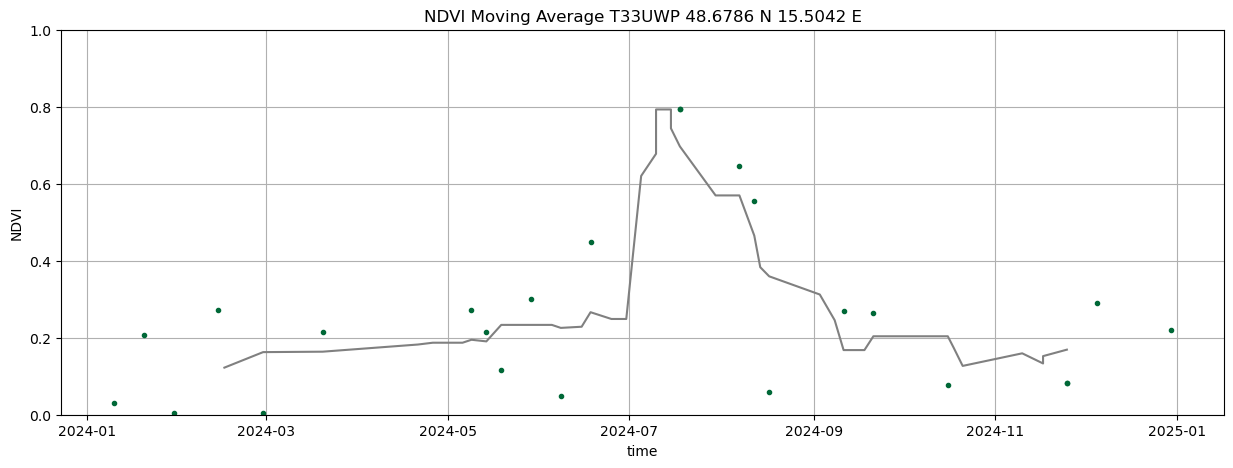

In [21]:
plt.figure(figsize=(15,5))
plt.title(f'NDVI Moving Average {tile} {np.round(lat, 4)} N {np.round(lon, 4)} E')
plt.plot(t, NDVI, ".", c='#006837')
plt.plot(tm, ma, c='grey')
plt.xlabel("time")
plt.ylabel("NDVI")
plt.ylim(0,1)
plt.grid()
plt.show()

In [22]:
from scipy import optimize

def lin(x, *params):
    return params[0] + params[1] * x
start_param_lin = [-7, 0]

def square(x, *params):
    return params[0] + params[1] * x + params[2] * x**2
start_param_square = [-4000, 0, 0]

nans = np.isnan(NDVI)

parameters = optimize.curve_fit(square, t.astype(float)[~nans], NDVI[~nans], start_param_square)[0]

NDVI_FIT = square(t.astype(float), *parameters)


In [23]:
parameters

array([-3.97548482e+03,  3.99141778e-01, -1.00175931e-05])

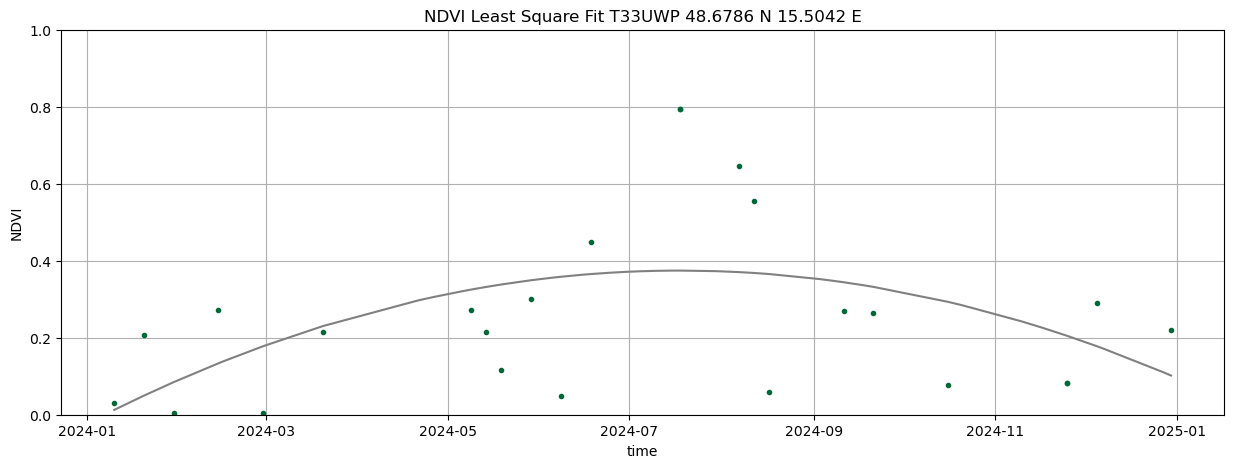

In [24]:
plt.figure(figsize=(15,5))
plt.title(f'NDVI Least Square Fit {tile} {np.round(lat, 4)} N {np.round(lon, 4)} E')
plt.plot(t, NDVI, ".", c='#006837')
plt.plot(t, NDVI_FIT, c='grey')
plt.xlabel("time")
plt.ylabel("NDVI")
plt.ylim(0,1)
plt.grid()
plt.show()